# 人脸识别

# 1. 实验介绍

## 1.1  实验内容

本实验采用特征脸（Eigenface）算法进行人脸识别。

特征脸（Eigenface）是第一种有效的人脸识别方法。在模型训练过程中，首先要根据测试数据求出平均脸，然后将前 K 个特征脸保存下来，利用这 K 个特征脸对测试人脸进行识别，此外对于任意给定的一张人脸图像，可以使用这K个特征脸对原图进行重建。

本次实验已经给出模型的代码，并准备了人脸数据集。你需要调整代码，完成多个实验（详见后面作业部分），并记录实验结果，回答问题。


## 1.2 实验要求

阅读并运行代码，了解特征脸（Eigenface）算法的实现过程，然后根据作业要求，更改代码，进行实验，并记录实验结果，回答问题。

## 1.3 参考文献

+ 特征脸，维基百科：https://zh.wikipedia.org/wiki/%E7%89%B9%E5%BE%81%E8%84%B8
+ Eigenface for Recognition： https://sites.cs.ucsb.edu/~mturk/Papers/jcn.pdf
+ The Yale Face Database： http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html

# 2.实验部分



## 2.1 试验数据介绍

本作业中使用的人脸图片来自 [Yale Face Database](http://cvc.yale.edu/projects/yalefacesB/yalefacesB.html)。整个数据集包含来自 10 名志愿者的 5760 张照片，每名志愿者的照片都包含 9 个不同的表情以及 64 种不同的光照条件。


本作业中，我们只使用其中 640 张正脸的照片。这些照片保存在 datasets/yaleBfaces-momodel 文件夹下。在左侧的文件列表中双击进入该文件夹，你将发现这些照片又被进一步的分为了 5 个不同的文件夹，其中 subset0 文件夹中的照片，拍摄时灯光是从正面照射的，所以整张照片都比较明亮，而其他的 4 个文件夹，从 subset1 到 subset4，灯光的照射角度越来越偏，所以照片中的阴影也越来越大。


在本次实验中，subset0 文件夹中的照片将作为训练集，而 subset1 到 subset4 这 4 个文件夹中的照片将作为测试集。

In [13]:
# 定义数据集的目录路径
yaleBfaces_data_base_path = "./datasets/yalebfaces-momodel/yaleBfaces"

下面我们来展示一张数据集里的人脸照片看看。

In [14]:
# 导入必要的包
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image
import os

我们定义一个读取单张图片的函数和一个展示照片的函数

In [15]:
def read_one_img(path):
    """
    根据路径读取一张人脸图片
    
    :param path: 图片的路径
    :return: 
    """
    # 图片路径
    # 以灰度模式读取图片
    img_sample = Image.open(path).convert('L')
    
    # 把图片格式转为 numpy array 格式
    img_sample = np.array(img_sample, 'uint8')
    
    return img_sample


def show_img(img):
    """
    展示一张图片
    
    :param img: numpy array 格式的图片
    :return: 
    """
    # 展示图片
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()

使用上面定义的函数，查看照片

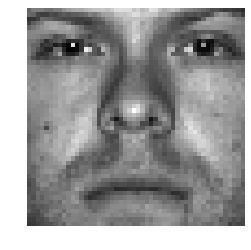

In [16]:
#输入照片的路径进行查看
img_sample = read_one_img(os.path.join(yaleBfaces_data_base_path, "subset0/person01_01.png"))
show_img(img_sample)


## 2.2 获取训练数据

我们定义 `get_images()` 函数，其输入是照片存放的文件夹路径，该函数将读取输入的文件夹路径下的所有照片，将其转为 1 维，统一保存到一个矩阵中，然依据图片名提取标签，最终，该函数将输出这个照片矩阵及其中每张照片的标签。

In [17]:
def get_images(path):
    """
    读取输入的文件夹路径下的所有照片，读取输入的文件夹路径下的所有照片，将其转为 1 维，
    统一保存到一个矩阵中，然依据图片名提取标签，最终该函数将输出这个照片矩阵及其中每
    张照片的标签。
    
    :param path: 照片存放的文件夹路径
    :return: numpy matrix 格式的处理好的图片，及 list 格式的各个图片的标签
    """
    # 首先获取所有人脸图片的路径
    image_paths = [os.path.join(path, f) for f in os.listdir(path) if
                   f.endswith('png')]
    
    # 所有的人脸区域图片都将保存在 images 这个矩阵中
    images = np.mat(np.zeros((len(image_paths), 2500)))
    
    trainset_labels = []
    
    # 对于每一张图片
    for index, image_path in enumerate(image_paths):
        
        # 读取图片并将其转为灰度图
        image_pil = Image.open(image_path).convert('L')
        
        # 把图片转为 numpy array 格式
        image = np.array(image_pil, 'uint8')
        
        # 把 2 维的平面图像转为 1 维
        img_1D = image.flatten()
        
        # 把处理后的图片保存到 images 中
        images[index, :] = img_1D
        
        # 提取图片名作为图片的标签
        trainset_labels.append(image_path.split('/')[-1][6:8])
        
    # 得到最终处理好的人脸图片和各个图片的标签
    return images.T, trainset_labels

我们从 subset0 文件夹下的取得全部 70 张人脸图片及其标签作为训练数据

In [18]:
# 调用前面定义好的 get_images 方法得到处理好的人脸数据
trainset, trainset_labels =  get_images(os.path.join(yaleBfaces_data_base_path, "subset0"))

我们可以看一下处理后的第一张图片的 shape 及其标签， 注意 shape[0] 等于 2500， 是因为我们将每一张图片是 50 * 50 的，我们将其从 2 维转为了 1 维。

In [19]:
trainset[:,1].shape

(2500, 1)

In [20]:
trainset_labels[0]

'10'

## 2.3 训练模型

下面给出了训练特征脸（Eigenface）算法的代码，其输入是人脸数据训练集，希望提取的主特征数，算法先根据测试数据求出平均脸，然后计算训练数据里每张脸与平均脸的差异，求差异矩阵的特征值和特征向量，取前 K 个特征向量，计算出 K 张特征脸，然后就可以利用这 K 个特征脸对测试人脸进行识别了。


具体算法细节，请查看上面给出的参考文献。

In [259]:
def eigen_train(trainset, K=10):
    """
    训练特征脸（eigenface）算法的实现
    
    :param trainset: 使用 get_images 函数得到的处理好的人脸数据训练集
    :param K: 希望提取的主特征数
    :return:  top-k 特征, 训练数据的平均脸, 和使用特征脸向量表示的训练数据
    """
    # 使用 numpy 的 mean 方法得到平均脸
    avg_img = np.mean(trainset, 1)
    
    # 得到每张脸与平均脸的差异的矩阵
    diff = trainset - avg_img
    
    # 使用 np.linalg.eig 方法得到差异矩阵的 特征值 eig_vals 以及 特征向量 eig_vects
    eig_vals, eig_vects = np.linalg.eig(
        np.mat(diff.T * diff) / float(diff.shape[1]))
    eig_vects = eig_vects / np.linalg.norm(eig_vects, axis=1)
    
    # 对主成分按重要性进行排序， 特征值越大，则说明该特征向量的重要性越大
    zip_eig_vals_vects = list(zip(eig_vals, eig_vects))
    zip_eig_vals_vects.sort(reverse=True)
    
    # 得到 top K 的特征向量
#     top_K_eig_vects = np.concatenate(
#         (list(zip_eig_vals_vects[i][1] for i in range(3, K))), axis=0)
    top_K_eig_vects = np.concatenate(
        (list(zip_eig_vals_vects[i][1] for i in range(K))), axis=0)
    
    # 得到特征脸向量
    face_vects = diff * top_K_eig_vects.T
    
    # 得到使用特征脸向量表示的训练数据
    trainset_vects = face_vects.T * diff   
    
    # 返回 top-k 特征, 训练数据的平均脸, 和使用特征脸向量表示的训练数据
    return top_K_eig_vects, avg_img, face_vects, trainset_vects

In [260]:
top_K_eig_vects, avg_img, face_vects, trainset_vects = eigen_train(trainset, K=10)

我们把平均脸的图片还原回 2 维，然后展示出来看看平均脸的样子

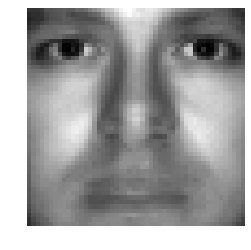

In [261]:
# 把平均脸还原为 2 维
IMAGE_SIZE = (50,50)
avg_img_reshape = avg_img.reshape(IMAGE_SIZE)

# 展示还原后的图片
show_img(avg_img_reshape)

我们把一张特征脸还原回 2 维，然后展示出来看看

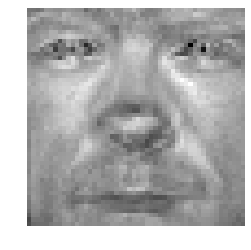

In [262]:
show_img(face_vects[:, 0].reshape(50, 50))

## 2.4 模型测试

接下来，我们使用上面得到的模型在测试集上进行测试。

首先读取 subset1 中的人脸数据作为测试集

In [263]:
# 调用前面定义好的 get_images 方法得到处理好的人脸数据
testset, testset_labels =  get_images(os.path.join(yaleBfaces_data_base_path, "subset3"))

然后使用特征脸（Eigenface）算法对 subset1 中的人脸照片进行预测，我们在这里定义了 eigenTest 函数，其输入是使用特征脸向量表示的训练数据，训练集的平均人脸数据，特征脸向量，训练集的标签数据，测试数据和测试数据的标签。

In [264]:
def eigen_test(trainset_vects, avg_img, face_vects, trainset_labels,
               testset, testset_labels):
    """
    用特征脸（eigenface）算法对输入的测试集进行预测，并打印出预测正确数和总测试样本数
    
    :param trainset_vects: 使用特征脸向量表示的训练数据
    :param avg_img: 训练集的平均人脸数据
    :param face_vects: 特征脸向量
    :param trainset_labels: 训练集的标签数据
    :param testset: 测试数据
    :param testset_labels: 测试数据的标签
    :return: None
    """
    # 计算测试数据和训练数据平均脸的差异
    diff_test_avg = testset - avg_img
    
    # 得到使用特征脸向量表示的测试数据
    test_vec = face_vects.T * diff_test_avg
    
    # 初始化模型预测的正确数为 0
    right_answer_number = 0
    
    for i in range(test_vec.shape[1]):
        # 对每一张测试图片，计算其特征脸向量表示与每一张训练图片的特征脸向量表示的欧式距离，
        # 得到与其最相似的图片，并将最相似照片的标签作为它的预测标签
        x = np.square(trainset_vects - test_vec[:, i]).sum(axis=0).argmin()
        predict_label = trainset_labels[x]
        
        # 如果标签与真实标签相同，则模型预测的正确数 +1
        if predict_label == testset_labels[i]:
            right_answer_number += 1
            
    # 查看模型预测正确数和总的测试照片数
    print('预测正确数：', right_answer_number)
    print('总测试样本数：', len(testset_labels))


In [265]:
eigen_test(trainset_vects, avg_img, face_vects, trainset_labels, testset,
           testset_labels)

预测正确数： 18
总测试样本数： 140


## 2.5 使用特征向量重建图片

特征脸（Eigenface）算法不仅可以用来进行人脸识别，对于任意给定的一张人脸照片，也可以使用得到的特征脸对原图进行重建。

我们使用上面从 subset0 中读取的那一张照片，我们再看一下原始的样子

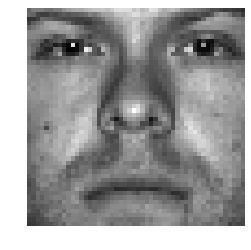

In [266]:
# 展示改图片的原始的样子
show_img(img_sample)

接下来，我们使用特征脸来表征原始照片，先将原始照片从 2 维转为 1 维，然后计算该样本照片与平均脸的差异，再得到使用特征脸向量表示的样本照片

In [267]:
# 先把照片从 2 维转为 1 维
img_sample_1D = img_sample.reshape(2500, 1)

# 计算该样本照片与平均脸的差异
diff_sample_avg = img_sample_1D - avg_img

# 得到使用特征脸向量表示的样本照片
sample_vec = face_vects.T * diff_sample_avg

我们来看看 sample_vec 的 shape

In [268]:
sample_vec.shape

(10, 1)

我们看到使用特征脸向量来表示原始图片，将原始图片的存储空间由 2500 降低到了 10，这就实现了图片压缩存储的目的。


接下来，我们进行图片的恢复。

In [269]:
# 恢复原始图片，并将其从 1 维转为 2 维
recovered_sample_img = (face_vects * sample_vec + avg_img).reshape(50, 50)

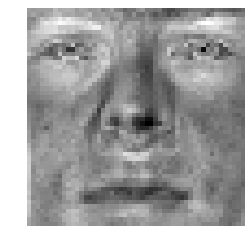

In [270]:
# 展示恢复后的图片
show_img(recovered_sample_img)

我们看到，图片在一定程度上进行了恢复，但很多细节丢失了。

# 3. 问题

### 问题 1:  观察主特征数量的变化是否会影响模型表现(20分)

使用不同数量（5 个，10个，20个）的主特征，来进行模型测试，观察随着主特征数量的增加，模型的表现是否会有变化。
在下方区域写下你的实验结果，并对这一现象进行解释。


=================== 答案 1 ======================

双击此区域开始编写第 1 题的答案，请勿在别的位置作答

|主特征数 | 正确数目 |  总测试数据 | 正确数目增长 |
|:-: | :-: | :-: | :-:|
|5 | 43 | 120 | Nan |
|10 | 71 | 120 | 18 |
|15 | 80 | 120 | 9 |
|20 | 82 | 120 | 2 |

从上表可以看出，随着主特征数量的增加，模型的表现逐渐增强；但是在增加同样数目特征的情况下，模型表现的提升逐渐减缓。可以从以下两个方面解释上述情况

- 一方面，增加特征数目增加了分类的信息量，信息学多模型准确率越高
- 另一方面，主特征按照特征值排序，后加入的特征其特征值越小，携带的信息量越小（表示原图片在对应的维度上越相似），对模型的提升程度也越小

==============================================

### 问题2:  观察剔除最主要的三个主特征后，使用剩余的特征进行模型预测，模型的表现如何(20分)

剔除最主要的三个主特征后，使用剩余的特征来进行模型测试，观察模型的表现是否会有变化。 在下方区域写下你的实验结果，并对这一现象进行解释。


=================== 答案 2 ======================

双击此区域开始编写第 2 题的答案，请勿在别的位置作答

主特征数 | 正确数目(-3) |  正确数目 | 正确数目增长  
-|-|-
5 | 34 | 43 | Nan |
10 | 75 | 71 | 41 |
15 | 82 | 80 | 7 |
20 | 84 | 82 | 2 |

除了5个主特征删2个主要特征这个极端的情况（2个主特征实在太少了），其他情况下剔除最主要的三个特征(表中 -3项)后，用剩余的特征进行模型测试，模型的表现变好了。这初看上去不符合常理，但是是有可能的，主要原因是：

PCA选择特征值最大的前n个特征向量来进行投影变换的**基本假设**是：对于所有数据，方差越大的维度信息越大。

而**对分类最重要的维度应该是类间分布相差最大的维度**。PCA认为所有数据维度中方差最大的维度最重要，这并不一定成立，因为可能**每个类别在该维度的分布很相似**，并起不到分类的作用。如下图

![pca_lda.png](https://i.loli.net/2019/10/28/R16VXsFA2Krdkiy.png)

假设红蓝为两类，由于PCA并不知道label，使用PCA将得到投影到红轴的特征向量的特征值最大，换言之PCA认为沿着红轴的属性信息最大。但是显然该**红轴维度上两个类的分布非常相似**，该维度对分类没有什么作用；反倒是方差较小的蓝轴维度类间分布相差较大，分类效果好。

所以，可以认为本问题中方差最大的几个维度在所有类别（每个人）的分布中相似，对分类没有什么贡献，加入反而干扰了分类的表现。

==============================================

### 问题 3:  观察照片中光照的变化是否会影响模型表现(20分)

我们知道从 subset1 到 subset4，照片中灯光的角度越来约偏，图片中的阴影也越来越大。那么光照的不同会对模型有影响吗？更改代码，在这 4 个测试集上测试模型，观察模型表现。在下方区域写下你的实验结果，并对这一现象进行解释。


=================== 答案 3 ======================

双击此区域开始编写第 3 题的答案，请勿在别的位置作答

数据集 | 正确数目 |  总测试数据 | 准确率  
-|-|-
subset1 | 71 | 120 | 0.5917 |
subset2 | 32 | 120 | 0.2667 |
subset3 | 18 | 140 | 0.1286 |
subset4 | 20 | 190 | 0.1053 |

通过观察subset1~4的预测准确率，可以看出，阴影越大识别准确率越低。解释：

阴影部分信息很少，像素值接近0。阴影越大，图片信息丢失越严重，有用的分类信息变少，导致测试准确率下降。

==============================================

In [271]:
def mse(img1, img2):
    # 以灰度模式读取图片
    img1 = Image.open(img1).convert('L')
    img2 = Image.open(img2).convert('L')
    # 把图片格式转为 numpy array 格式
    img1 = np.array(img1, 'uint8')
    img2 = np.array(img2, 'uint8')
    
    err = np.sum((img1-img2)**2)
    return (err/(img1.shape[0]*img1.shape[1]))

print('3', mse('./results/ori.png', './results/3.png'))
print('5', mse('./results/ori.png', './results/5.png'))
print('10', mse('./results/ori.png', './results/10.png'))

3 40.70859857253087
5 40.94100437242798
10 39.77293113425926


### 问题 4:  分别使用 top 3, top5, top 10 主特征重建照片，观察生成的图片(20分)

从 subset0 中的挑选一张照片，然后分别使用 top 3, top5, top 10 主特征重建这张图片，观察重建后的图片与原图片的差异。把你的观察结果写在下面。


=================== 答案 4 ======================

双击此区域开始编写第 4 题的答案，请勿在别的位置作答
![all_faces.png](https://i.loli.net/2019/10/21/NHYys3CXVukI48f.png)

视觉来看，主特征数目越多，重建后阴影越少，并且与原图片越相似，越细腻。

我分别计算了三个重构图片与与原图的像素均方误差，分别是40.7(top3) 40.9(top5) 39.7(top10)，top3与top5的mse差别不大，但是top10重构图片的mse比前两项低，说明top10重建图片比top3 top5效果更好。

==============================================

### 问题 5:  调查人脸识别技术的发展(20分)

做一些人脸识别技术发展情况（最新的技术、应用的场景等）的调查，把你的调查结果写在下面。


=================== 答案 5 ======================

#### 发展历史

##### stage 1: 1965-1990年

主要基于人脸几何结构特征和模版匹配的方法，利用几何特征提取人眼、口、鼻等重要特征点的位置，以及眼睛等重要器官的几何直观形状作为分类特征，并据此计算特征点之间相互位置和距离，用来衡量两幅人脸图像的相似程度。

##### stage 2: 1991-1997年

基于整体的方法，包括主成分分析（PCA）方法、线性鉴别分析（LDA）方法等。这些方法通过寻找一组投影向量，将人脸降维，再将低维特征送入类似SVM等机器学习分类器中进行人脸分类。

##### stage 3: 1998-2013年

多借助深度相机、结构光、红外相机等设备，使得人脸识别的精度大大提高。

同时还有早期的基于特征的分类方法，在人脸不同位置提取局部特征，得到的结果往往比整体方法更加具有鲁棒性。类似的有从图像块中提取HOG、LBP、SIFI、SURF特征，将各模块局部特征的向量串联，作为人脸的表示。

也有综合方法，先使用基于特征的方法获得局部特征，再使用子空间法（比如PCA、LDA）获得低维特征，将基于整体与基于局部特征的方法。这类方法中，GaussianFace在LFW上获得了最好的精度98.52%，几乎匹敌很多后来出现的深度学习方法。

##### stage 4: 2006-至今

多基于深度学习，2015年，Google团队的FaceNet在LFW数据集上得平均准确率达到了99.63%，基于深度学习的人脸识别的准确率已经高于人类本身，深度学习在人脸识别领域基本占据了统治地位。

#### 最新技术

>   最新的技术主要基于deep learning，这里主要介绍基于神经网络的最新技术。

人脸的表达模型分为2D人脸和3D人脸。2D人脸识别研究的时间相对较长，方法流程也相对成熟，在多个领域都有使用，但由于2D信息存在深度数据丢失的局限性，无法完整的表达出真实人脸，所以在实际应用中存在着一些不足，例如识别准确率不高、活体检测准确率不高等。

3D人脸模型比2D人脸模型有更强的描述能力，能更好的表达出真实人脸，所以基于3D数据的人脸识别不管识别准确率还是活体检测准确率都有很大的提高。

##### 2D人脸识

2D人脸识别模型比较有名的有[MTCNN](https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf)和[FaceNet](https://arxiv.org/pdf/1503.03832.pdf)

###### MTCNN

MTCNN一个深度卷积多任务的框架，这个框架利用了检测和对准之间固有的关系来增强他们的性能。特别是，在预测人脸及脸部标记点的时候，通过3个CNN级联的方式对任务进行从粗到精的处理。基本流程如下：

1. 使用P-Net是一个全卷积网络，用来生成候选窗和边框回归向量(bounding box regression vectors)。使用Bounding box regression的方法来校正这些候选窗，使用非极大值抑制（NMS）合并重叠的候选框。全卷积网络和Faster R-CNN中的RPN一脉相承。

2. 使用R-Net改善候选窗。将通过P-Net的候选窗输入R-Net中，拒绝掉大部分false的窗口，继续使用Bounding box regression和NMS合并。

3. 最后使用O-Net输出最终的人脸框和特征点位置。和第二步类似，但是不同的是生成5个特征点位置

###### FaceNet

Google工程师Florian Schroff，Dmitry Kalenichenko，James Philbin提出了人脸识别FaceNet模型，该模型没有用传统的softmax的方式去进行分类学习，而是抽取其中某一层作为特征，学习一个从图像到欧式空间的编码方法，然后基于这个编码再做人脸识别、人脸验证和人脸聚类等。
FaceNet主要用于验证人脸是否为同一个人，通过人脸识别这个人是谁。FaceNet的主要思想是把人脸图像映射到一个多维空间，通过空间距离表示人脸的相似度。同个人脸图像的空间距离比较小，不同人脸图像的空间距离比较大。这样通过人脸图像的空间映射就可以实现人脸识别，FaceNet中采用基于深度神经网络的图像映射方法和基于triplets（三联子）的loss函数训练神经网络，网络直接输出为128维度的向量空间。

##### 3D人脸识别

目前3D人脸识别技术按照摄像头成像原理主要分为：3D结构光、TOF、双目立体视觉。

###### 3D结构光
3D结构光通过红外光投射器，将具有一定结构特征的光线投射到被拍摄物体上，再由专门的红外摄像头进行采集。主要利用三角形相似的原理进行计算，从而得出图像上每个点的深度信息，最终得到三维数据。


基于3D结构光的人脸识别已在一些智能手机上实际应用，如国外使用了超过10亿张图像（IR和深度图像）训练的FaceId。

###### TOF
TOF简单的说就是激光测距，照射光源一般采用方波脉冲调制，根据脉冲发射和接收的时间差来测算距离。


采用TOF的方式获取3D数据主要在Kinect上实现，主要获取并处理的是人体的姿态数据。

###### 双目立体视觉
双目是基于视差原理并由多幅图像获取物体三维几何信息的方法。由双摄像机从不同角度同时获得被测物的两幅数字图像，并基于视差原理恢复出物体的三维几何信息，从而得出图像上每个点的深度信息、最终得到三维数据。

#### 应用场景

人脸识别作为一项热门的技术，在很多领域都有着广泛的应用。以下列举几个应用场景

##### 刑侦破案

通过查询目标人像数据寻找数据库中是否存在重点人口基本信息。例如在机场或车站安装系统以抓捕在逃案犯。

##### 门禁系统

受安全保护的地区可以通过人脸识别辨识试图进入者的身份。人脸识别系统可用于企业、住宅安全和管门禁人脸识别，如人脸识别门禁考勤系统，人脸识别防盗门等。

##### 摄像监视系统

 可在机场、体育场、超级市场等公共场所对人群进行监视，例如在机场安装监视系统以防止恐怖分子登机。如银行的自动提款机，用户卡片和密码被盗，就会被他人冒取现金。

##### 身份辨识

例如Apple公司手机的FaceID识别系统，大大提高了认证的便捷性。

==============================================